# Generating some 3-dimensional sample data

In [2]:
import numpy as np
import numpy.random
np.random.seed(2342344218) # random seed for consistency


mu_vec1 = np.array([0,0,0])
cov_mat1 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class1_sample = np.random.multivariate_normal(mu_vec1, cov_mat1, 20).T
assert class1_sample.shape == (3,20), "The matrix has not the dimensions 3x20"

mu_vec2 = np.array([1,1,1])
cov_mat2 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class2_sample = np.random.multivariate_normal(mu_vec2, cov_mat2, 20).T
assert class1_sample.shape == (3,20), "The matrix has not the dimensions 3x20"

# implementing PCA

Populating the interactive namespace from numpy and matplotlib


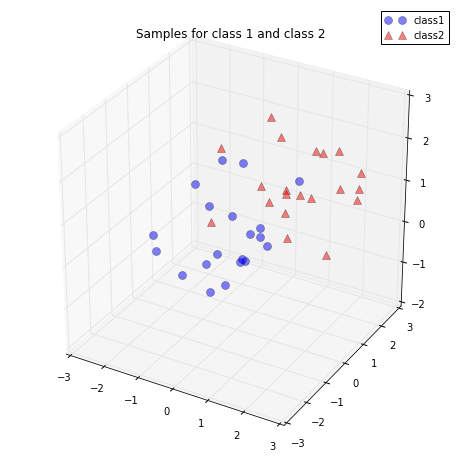

In [3]:
%pylab inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(class1_sample[0,:], class1_sample[1,:], class1_sample[2,:], 'o', markersize=8, color='blue', alpha=0.5, label='class1')
ax.plot(class2_sample[0,:], class2_sample[1,:], class2_sample[2,:], '^', markersize=8, alpha=0.5, color='red', label='class2')

plt.title('Samples for class 1 and class 2')
ax.legend(loc='upper right')
plt.savefig('PCA_1.png', dpi=200)
plt.show()

# 1. Taking the whole dataset ignoring the class labels

In [4]:
all_samples = np.concatenate((class1_sample, class2_sample), axis=1)
assert all_samples.shape == (3,40), "The matrix has not the dimensions 3x40"

# 2. Computing the d-dimensional mean vector

In [5]:
mean_x = np.mean(all_samples[0,:])
mean_y = np.mean(all_samples[1,:])
mean_z = np.mean(all_samples[2,:])

mean_vector = np.array([[mean_x],[mean_y],[mean_z]])

print('Mean Vector:\n', mean_vector)

Mean Vector:
 [[ 0.49888885]
 [ 0.42918732]
 [ 0.76854895]]


# 3. Computing the Scatter Matrix

In [6]:
scatter_matrix = np.zeros((3,3))
for i in range(all_samples.shape[1]):
    scatter_matrix += (all_samples[:,i].reshape(3,1) - mean_vector).dot((all_samples[:,i].reshape(3,1) - mean_vector).T)
print('Scatter Matrix:\n', scatter_matrix)

Scatter Matrix:
 [[ 53.6788665   20.37642776  17.76920267]
 [ 20.37642776  49.73077863  11.87197376]
 [ 17.76920267  11.87197376  34.36532162]]


# 4. Computing eigenvectors and corresponding eigenvalues

In [7]:
# eigenvectors and eigenvalues for the from the scatter matrix
eig_val_sc, eig_vec_sc = np.linalg.eig(scatter_matrix)

for i in range(len(eig_val_sc)):
    eigvec_sc = eig_vec_sc[:,i].reshape(1,3).T

    print('Eigenvector {}: \n{}'.format(i+1, eigvec_sc))
    print('Eigenvalue {} from scatter matrix: {}'.format(i+1, eig_val_sc[i]))
    print(40 * '-')

Eigenvector 1: 
[[-0.69249425]
 [-0.59408177]
 [-0.40929031]]
Eigenvalue 1 from scatter matrix: 81.66180882490045
----------------------------------------
Eigenvector 2: 
[[-0.51969396]
 [ 0.01730165]
 [ 0.85417729]]
Eigenvalue 2 from scatter matrix: 23.7947495235757
----------------------------------------
Eigenvector 3: 
[[ 0.50036976]
 [-0.80421857]
 [ 0.32072201]]
Eigenvalue 3 from scatter matrix: 32.318408405803495
----------------------------------------


## Visualizing the eigenvectors

Populating the interactive namespace from numpy and matplotlib


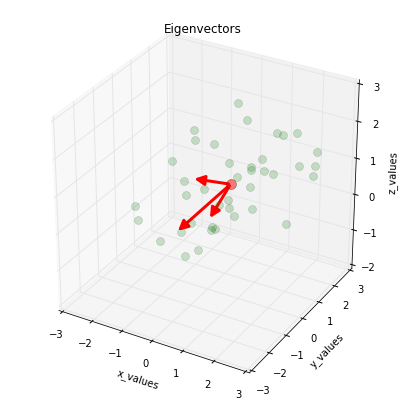

In [8]:
%pylab inline

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(all_samples[0,:], all_samples[1,:], all_samples[2,:], 'o', markersize=8, color='green', alpha=0.2)
ax.plot([mean_x], [mean_y], [mean_z], 'o', markersize=10, color='red', alpha=0.5)
for v in eig_vec_sc.T:
    a = Arrow3D([mean_x, v[0]], [mean_y, v[1]], [mean_z, v[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)
ax.set_xlabel('x_values')
ax.set_ylabel('y_values')
ax.set_zlabel('z_values')

plt.title('Eigenvectors')

plt.savefig('PCA_2.png', dpi=200)

plt.show()

# 5.1. Sorting the eigenvectors by decreasing eigenvalues

In [9]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val_sc[i]), eig_vec_sc[:,i]) for i in range(len(eig_val_sc))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
for i in eig_pairs:
    print(i[0])

81.6618088249
32.3184084058
23.7947495236


# Choosing k eigenvectors with the largest eigenvalues

In [10]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(3,1), eig_pairs[1][1].reshape(3,1)))
print('Matrix W:\n', matrix_w)

Matrix W:
 [[-0.69249425  0.50036976]
 [-0.59408177 -0.80421857]
 [-0.40929031  0.32072201]]


In [11]:
print('Variance explained:\n')
eigv_sum = sum(eig_val_sc)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variance explained:

eigenvalue 1: 59.27%
eigenvalue 2: 23.46%
eigenvalue 3: 17.27%


# 6. Transforming the samples onto the new subspace

In [12]:
transformed = matrix_w.T.dot(all_samples)
assert transformed.shape == (2,40), "The matrix is not 2x40 dimensional."

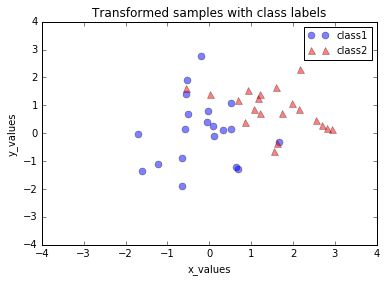

In [109]:
plt.plot(transformed[0,0:20], transformed[1,0:20], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(transformed[0,20:40], transformed[1,20:40], '^', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples with class labels')

plt.savefig('PCA_3.png', dpi=200)

plt.show()

# Для продвинутых

Математическое содержание метода главных компонент — это спектральное разложение ковариационной матрицы $C$, то есть представление пространства данных в виде суммы взаимно ортогональных собственных подпространств $C$, а самой матрицы 
$C$ — в виде линейной комбинации ортогональных проекторов на эти подпространства с коэффициентами ${\displaystyle  \lambda_i }$. Если ${\displaystyle \operatorname{X}=\left\{x_1,..., x_m \right\}^T}$ — матрица, составленная из векторов-строк (размерности $n$) центрированных данных, то ${\displaystyle  C =\frac{1}{m-1} \operatorname{X}^T\operatorname{X}}$ и задача о спектральном разложении ковариационной матрицы $C$ превращается в задачу о сингулярном разложении матрицы данных ${\displaystyle \operatorname{X}}$.

<b>Сингулярное разложение (Singular Value Decomposition, SVD)</b> — декомпозиция вещественной матрицы с целью ее приведения к каноническому виду. Сингулярное разложение является удобным методом при работе с матрицами. Оно показывает геометрическую структуру матрицы и позволяет наглядно представить имеющиеся данные. Сингулярное разложение используется при решении самых разных задач — от приближения методом наименьших квадратов и решения систем уравнений до сжатия изображений. При этом используются разные свойства сингулярного разложения, например, способность показывать ранг матрицы, приближать матрицы данного ранга. SVD позволяет вычислять обратные и псевдообратные матрицы большого размера, что делает его полезным инструментом при решении задач регрессионного анализа.
Для любой вещественной ($n\times n$)-матрицы A существуют две вещественные ортогональные ($n\times n$)-матрицы $U$ и$ V$ такие, что$ U^T A V $— диагональная матрица $\Lambda$,$$U^TAV=\Lambda.$$
Матрицы $U$ и $V$ выбираются так, чтобы диагональные элементы матрицы $\Lambda$ имели вид
$\lambda_1 \geq \lambda_2 \geq ... \geq \lambda_r > \lambda_{r+1}=...=\lambda_n=0$,
где $r$ — ранг матрицы $A$. В частности, если $A$ невырождена, то
$$\lambda_1 \geq \lambda_2 \geq ... \geq \lambda_n > 0.$$
Индекс r элемента $\lambda_r$ есть фактическая размерность собственного пространства матрицы  $A$.
Столбцы матриц $U$ и $V$ называются соответственно левыми и правыми сингулярными векторами, а значения диагонали матрицы $\Lambda$ называются сингулярными числами.
Эквивалентная запись сингулярного разложения — $$A=U\Lambda V^T$$.

Сингулярное разложение обладает свойством, которое связывает задачу отыскания сингулярного разложения и задачу отыскания собственных векторов. Собственный вектор $\mathbf{x}$ матрицы $A$ — такой вектор, при котором выполняется условие $A\mathbf{x}=\lambda\mathbf{x}$, число $\lambda$ называется собственным числом. Так как матрицы $U$ и $V$ ортогональные, то
\begin{array}{c}AA^T=U\Lambda V^TV\Lambda U^T=U\Lambda^2 U^T,\\A^TA=V\Lambda U^TU\Lambda V^T=V\Lambda^2 V^T.\\ \end{array}
Умножая оба выражения справа соответственно на $U$ и $V$ получаем
\begin{array}{c}AA^TU=U\Lambda^2,\\A^TAV=V\Lambda^2.\\\end{array}
Из этого следует, что столбцы матрицы $U$ являются собственными векторами матрицы $AA^T$, а квадраты сингулярных чисел $\Lambda=\mbox{diag}(\lambda_1,...,\lambda_r)$ — ее собственными числами. Также столбцы матрицы $V$ являются собственными векторами матрицы $A^TA$, а квадраты сингулярных чисел являются ее собственными числами.

$C=VSU^⊤USV^⊤/(n−1)=VS^2/n−1V^⊤,$

# Проверим, действительно ли сингулярное разложение $X$ есть спектральное разложение ковариационной матрицы $X \cdot X^T$(разложение на собственные вектора)

## Повторим код для нахождения собственных векторов, для ковариационной матрицы(Будет отличие от Scatter Matrix на множитель $ \frac{1}{N-1}$.

In [125]:
cov_mat = np.cov([all_samples[0,:],all_samples[1,:],all_samples[2,:]])
print('Covariance Matrix:\n', cov_mat)

eig_val_sc, eig_vec_sc = np.linalg.eig(cov_mat)

for i in range(len(eig_val_sc)):
    eigvec_sc = eig_vec_sc[:,i].reshape(1,3).T

    print('Eigenvector {}: \n{}'.format(i+1, eigvec_sc))
    print('Eigenvalue {} from covariance matrix: {}'.format(i+1, eig_val_sc[i]))
    print(40 * '-')

Covariance Matrix:
 [[ 1.37638119  0.52247251  0.45562058]
 [ 0.52247251  1.27514817  0.30440958]
 [ 0.45562058  0.30440958  0.88116209]]
Eigenvector 1: 
[[-0.69249425]
 [-0.59408177]
 [-0.40929031]]
Eigenvalue 1 from covariance matrix: 2.0938925339718075
----------------------------------------
Eigenvector 2: 
[[-0.51969396]
 [ 0.01730165]
 [ 0.85417729]]
Eigenvalue 2 from covariance matrix: 0.6101217826557869
----------------------------------------
Eigenvector 3: 
[[ 0.50036976]
 [-0.80421857]
 [ 0.32072201]]
Eigenvalue 3 from covariance matrix: 0.8286771386103458
----------------------------------------


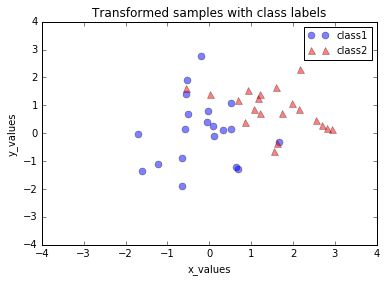

In [111]:
plt.plot(transformed[0,0:20], transformed[1,0:20], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(transformed[0,20:40], transformed[1,20:40], '^', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples with class labels')

plt.savefig('PCA_3.png', dpi=200)

plt.show()

## Убедимся вектора соноправлены с правым сингулярным вектором матрцы данных $X$

## Сингулярно разложим матрицу данных.

In [124]:
U,s,V = np.linalg.svd(all_samples.T)
print("right singular vector matrix \n",V, end='\n\n')
print("singulars \n",s)
#Выберем вектора соответсвующие наибольшим сингулярам.
V = np.concatenate((V.T[:, 0], V.T[:, 2])).reshape(3,2)


right singular vector matrix 
 [[ 0.62818122  0.53172336  0.56803048]
 [-0.27543339  0.83474827 -0.47679321]
 [-0.72768455  0.14305798  0.67082755]]

singulars 
 [ 10.86589292   5.76473609   5.23693886]


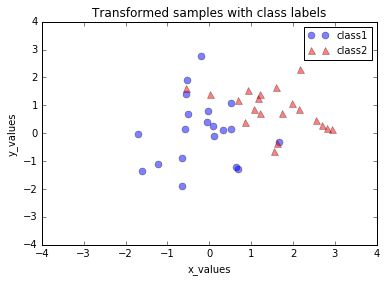

In [126]:

transformed = all_samples.T.dot(V).T
plt.plot(transformed[0,0:20], transformed[1,0:20], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(transformed[0,20:40], transformed[1,20:40], '^', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples with class labels')

plt.savefig('PCA_4.png', dpi=200)

plt.show()

-1.1023797400374369